### GLACIER AREA CALCULATOR ### 

This project will primarily use the USGS Python Package to identify, download and present Landsat imagery between 1985 - 2024 at the Kenai Mountains in Alaska.


##  TO DO LIST FOR THE STUDY  ## 

---AFTER LANDSAT DONE-----
- Generate a comparison Table/Template for all results acquired
- Maybe an Arc Shapefile

In [5]:
# List of modules required for this study

# USGS will need to be downloaded to the users conda environment (using pip install usgs)
import usgs
from usgs import api
import os
import requests
import tarfile
import rasterio
from rasterio.windows import from_bounds
import numpy as np
import matplotlib.pyplot as plt

## Getting Logged in and Set up ##

In order for this script to work, users will require both a valid account on the USGS Earth Explorer Website (https://earthexplorer.usgs.gov/) and an authorised Api Key (This can be applied for by following the attached link https://ers.cr.usgs.gov/).

In [6]:
# Open and read the Username and Api Key/Token for the USGS account
with open('C:/Users/couse/.usgs_user', 'r') as usertext:
    username = usertext.read()
with open('C:/Users/couse/.usgs_token', 'r') as tokentext:
    password = tokentext.read()
    
# Log in using the above information in the script attached below
login = api.login(username, password, save=True)

#The API Key (token) is extracted separately as it will be used in the script to search for and download Landsat imagery
api_key = login['data']
print("Logged in")

Logged in


To identify and search for the required Landsat scenes in this study we are going to use the api.scene_search() function as this will be the primary method for getting the correct images before we download them. 

For the scene searches in this study we are going to use the following:
- Dataset ID (dataset)
- Latitude and Longitude (lat and lng)
- Earth Explorer allows us to create a bounding box to get available images that cover those areas (ll and ur - Lower left corner and Upper Right corner for the bounding box respectively)
- Start and End date (start_date and end_date)
- The extracted Api key (api_key)

Future adaptations could include filtering image selection based on cloud coverage to ensure that images used are cloud free.

We are going to use dataset_search to identify what Landsat datasets are available and importantly the exact 'dataset' which we will use to download and extract the specific scenes needed for this study

In [ ]:
# Landsat imagery comes from the EarthExplorer dataset (node), we will do a search and print out all Landsat datasets in the Earth Explorer node
satellite_avail = api.dataset_search("landsat", "EE")
for dataset in satellite_avail['data']:
        print(dataset['datasetAlias']) #Prints out names of all available datasets

All available scenes are printed above. In this project we are going to use the 'landsat_tm_c2_l1' (1986, 1995 and 2009) and the 'landsat_ot_c2_l1' (2014 and 2024) datasets to acquire imagery of the Kenai Mountain Glaciers. The next step is to search for the Landsat images that will be used for the study. You can get the Bounding box coordinates and landsat image information on the USGS Earth Explorer website (https://earthexplorer.usgs.gov/).
In this study, a set date has been used to get the exact image required, however the date range can be adjusted to get see the available products ether across a range of dates or on different days.

## Downloading and analysing the 1986 Landsat Scene ## 

In [7]:
# In this cell we will use the search function to get the 'entity_id' Landsat scene used in the study
results_1986 = api.scene_search(
    # Landsat dataset used for 1986 image
    dataset = "landsat_tm_c2_l1", 
    # The latitude of the image (Can be changed for different locations)
    lat = 60.09345, 
    # The longtitude of the image (Can be changed for different locations)
    lng = -151.07395, 
    # The Latitude and Longtitude of the Lower left corner of the Bounding Box in EE
    ll = {"longitude" : -151.7075, "latitude" : 59.1140}, 
    # The Latitude and Longtitude of the Upper Right corner of the Bounding Box in EE
    ur = {"longitude" : -150.1913, "latitude" : 59.9276},
    # The start date of the search range
    start_date = "1986-09-11", 
    # The end date of the search range
    end_date = "1986-09-13", 
    # The Users Api key
    api_key=api_key 
)
#The next lines of script will loop through each 'scene' that appears in the results and will print out the 'entity_id' which will be used in the dataset download.
for scene in results_1986['data']['results']:
    print("The Entity ID of the 1986 Landsat scene is",(scene['entityId'])) 

The Entity ID of the 1986 Landsat scene is LT50690181986255XXX05


Now that the Entity ID is known we can now download the Band files which we will use to build a false colour composite image of the Kenai Mountains.

In [ ]:
# This cell will provide the different download options for the Landsat dataset
api.dataset_download_options("landsat_tm_c2_l1")                             

In this study we are going to use the 'Landsat Collection 2 Level-1 Product Bundle' to download all the different bands. For all downloads we are using the product_id that incldues the downlaod system 'ls_zip'. The product ID code with the downlaod option will be used in the download request to download the tar file into the repository. We are download all of the datasets as a tarfile as when the images are download from the USGS dataset it combines all images into a single file. If images are downloaded as a zip file it doesn't allow the user to extract the file contents as all images are individually compressed.

Therefore, in this project all images that are downloaded from the USGS are downloaded in the tar file format so that the user can used the tarfile module to easily extract images into the directory folder.

The next cell will download the Landsat band images associated with the entity_id that we got from the scene search above. The download_requests functions will return a URL which can be used to download the band file folder to our chosen directory. We will use this URL to direct our download to the 1986Data folder as a Tar file.

In [32]:
# We use the OS module to create a new folder for all the Kenai Mountains data to be stored 
# We also create a "1986Data" folder to store data that belongs to this time period
os.makedirs("KenaiMountains/1986Data", exist_ok=True) 

# This functions will return the available download urls for the Landsat scene
KM_1986 = api.download_request(
    dataset="landsat_tm_c2_l1", # Landsat dataset
    entity_id="LT50690181986255XXX05", # Landsat scene entity id returned from the scene search
    product_id="5e83d0a0f94d7d8d", # Product id for the Landsat Collection 1 Level 1 ls.zip
)

 # Download the Landsat data using the url provided by the download_request function from the EE node
if 'data' in KM_1986 and 'availableDownloads' in KM_1986['data']:
    # Identifies if the above Landsat is available to be downloaded
    KM_1986Avail = KM_1986['data']['availableDownloads'] 
    if KM_1986Avail:
        KM1986downloadurl = KM_1986Avail[0]['url']# Use the first download url retrieved from download_request
        KM_1986File = os.path.join("KenaiMountains/1986Data", f"LT50690181986255XXX05.tar")# Set the file path to download into the '1986Data' folder created above
        KM1986url = requests.get(KM1986downloadurl, stream=True)# Use the requests module to get the URL stored in the 'KM1986downloadurl' variable

        # Write the downloaded file in binary mode to avoid corruption during download
        with open(KM_1986File, "wb") as f: 
            # Download in 8Kb chunks to avoid issues with larger datasets (more relevant to 'landsat_ot_c2_l1' scenes
            for chunk in KM1986url.iter_content(chunk_size=8192): 
                # Then we use .write to download the data in chunk to our chosen folder
                if chunk:
                    f.write(chunk)

# When download is successful it will print the following text
# The download may take a few minutes but can be monitored by refreshing the directory folder (1986Data)
print("1986 Kenai Mountain images downloaded!")

1986 Kenai Mountain images downloaded!


In [33]:
# We extract the Landsat images from the .tar file that we downloaded from the USGS EE node
with tarfile.open("KenaiMountains/1986Data/LT50690181986255XXX05.tar", 'r') as KM1986Tar:
    KM1986Tar.extractall("KenaiMountains/1986Data")

# Text will display whenever images have been successfully extracted into the 1986Data folder
print("Images have been successfully extracted")

Images have been successfully extracted


Now that the images for the 1986 dataset have been downloaded we will build a false colour composite image of the Landsat scene

As part of this we are going to use Rasterio to open, read and stack the images to create a new 3D array (using NumPY). 
This stack combines the necessary band combination to create a False Colour Composite Image of the Landsat scene.
We then use matplotlib to present the created False Colour Composite image to ensure that the correct bands have been used and thqt the stack has been successful.

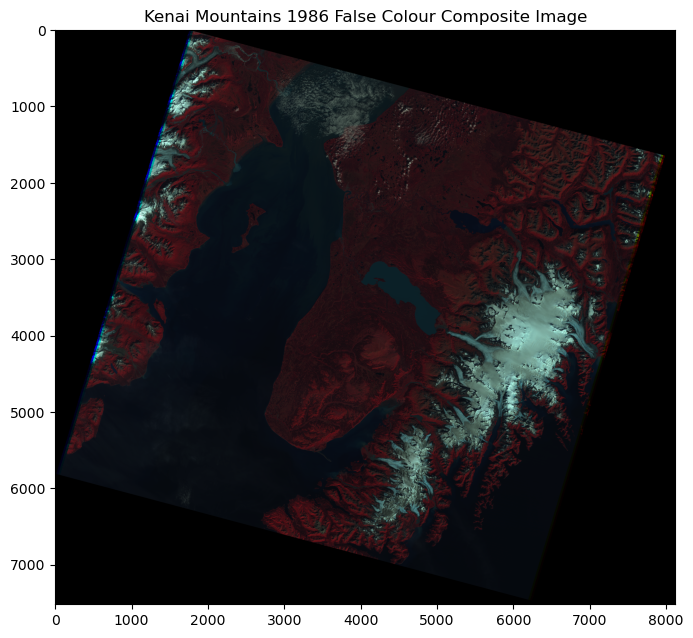

In [34]:
# We use Rasterio to open the paths to the Landsat scene Band TIF files
with rasterio.open("KenaiMountains/1986Data/LT05_L1TP_069018_19860912_20200917_02_T1_B4.TIF") as KM1986_B4IMG:
    KM86B4 = KM1986_B4IMG.read(1) # The paths are defined as B4 (NIR), B3 (Red) and B2 (Green) respectively
with rasterio.open("KenaiMountains/1986Data/LT05_L1TP_069018_19860912_20200917_02_T1_B3.TIF") as KM1986_B3IMG:
    KM86B3 = KM1986_B3IMG.read(1)
with rasterio.open("KenaiMountains/1986Data/LT05_L1TP_069018_19860912_20200917_02_T1_B2.TIF") as KM1986_B2IMG:
    KM86B2 = KM1986_B2IMG.read(1)

# We stack bands using NumPy module to create a single 3D Array
KM1986_FFCstack = np.dstack((KM86B4, KM86B3, KM86B2))

# Print the Stacked image to show the False Colour Composite for the 1986 Landsat scene
plt.figure(figsize=(8, 8)) # create a figure of size 8x8 (representing the page size in inches)
plt.imshow(KM1986_FFCstack) # The figure will show the False Colour Composite Image for 1986
plt.title("Kenai Mountains 1986 False Colour Composite Image") # The Figure Title
plt.show()

Now that the False Colour Composite Image has been successfully built. We will save the image to the 1986Data folder so that it can be trimmed and then used for the glacier mask later in the session.

We update image profile for the False Colour Composite image using the NIR band as the source, this ensures that the created TIF keeps the same metadata structure as it will be used in the following steps to create a trim and Glacier mask.

The metadata in the profile includes:
- Pixel Height and Width
- Coordinate System
- Transformation
- Driver/File Format

We then update the Metadata of the new image to include:
- The number of bands (as the NIR is a single band)
- dtype (ensures that the image is saved as a TIF)

In [35]:
# Now that the False Colour Composite Image has been created, we will need to save the image  

# First we will open one of the bands to get its profile and use it as a source
with rasterio.open('KenaiMountains/1986Data/LT05_L1TP_069018_19860912_20200917_02_T1_B4.TIF') as KM1986_source:
    KM1986_ImgProfile = KM1986_source.profile

# We then update the profile for all of the bands in the False Colour Composite using the source
KM1986_ImgProfile.update(
    count=3,  # The count is set to 3 as we are using 3 bands (NIR, Red and Green)
)

# Finally we save the False Colour Composite to the Kenai Mountains folder
with rasterio.open('KenaiMountains/1986Data/KM1986_FullFCC.TIF', 'w', **KM1986_ImgProfile) as KM1986_FCCdownload:
# We then use the .write function to save the False Colour image to the Kenai Mountains 1986 folder
# We use .transpose to chnage the shape of the array to match the format expected by rasterio when writing/saving the image to the folder (Bands, Rows and Columns respectively) 
    KM1986_FCCdownload.write(KM1986_FFCstack.transpose(2, 0, 1))  
print("Image has been saved as KM1986_FullFCC.TIF")

Image has been saved as KM1986_FullFCC.TIF


Now that the Full False Colour Composite Image for the 1986 Landsat scene ahs been successfully created. We need to trim the image so that the only area included in the Glacier Mask is the Kenai Mountains.

This is useful as it prevent Glacier Ice and Snow from adjacent mountains influencing the total Glacier area for the 1986 period.

To do this we need to adjust the bounds (extent) of the Full False Colour Composite Image to only include the Kenai Mountains.

To include more area (zoom out) on the image:
- Decrease 'left'
- Increase 'right'
- Decrease 'bottom'
- Increase 'top'

To include less area (Zoom in):
- Increase 'left'
- Decrease 'Right'
- Increase 'bottom'
- Decrease 'top'

In [36]:
# Use Rasterio to get the Bounds of the full False Colour Composite Image
with rasterio.open('KenaiMountains/1986Data/KM1986_FullFCC.TIF') as KM1986FCCsrc:
    print(KM1986FCCsrc.bounds)

BoundingBox(left=481185.0, bottom=6551985.0, right=724815.0, top=6777615.0)


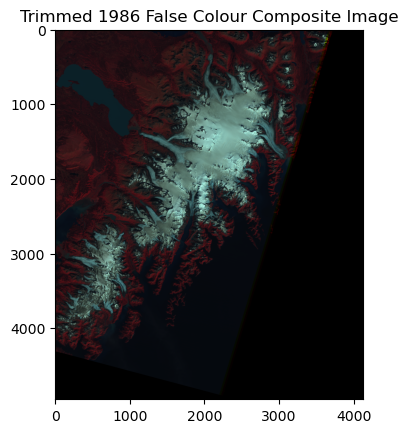

In [46]:
# Define a new Bounding Box by changing the values from .bound above
BoundingBox = {"left": 601185.0,"bottom": 6551985.0, # Values can be adjusted
               "right": 734815.0,"top": 6700615.0} # Values can be adjusted

# Open the Full False Colour Composite Image
with rasterio.open('KenaiMountains/1986Data/KM1986_FullFCC.TIF') as KM1986Cropsrc:
    # Use the new BoundingBox to create a trim window
    KM1986Trim = from_bounds(BoundingBox["left"], BoundingBox["bottom"], BoundingBox["right"], BoundingBox["top"], transform=KM1986Cropsrc.transform) # transform helps convert the pixel value in the Bounding box to real coordinate on the image
    
    # Read the data within the trim window
    KM1986Trim_Data = KM1986Cropsrc.read(window=KM1986Trim)
    # Update the metadata and profile of the trimmed area
    KM1986Trim_Transform = KM1986Cropsrc.window_transform(KM1986Trim)
    KM1986Trim_profile = KM1986Cropsrc.profile.copy()
    # Update the Trimmed TIF metadata to include the correct Pixel Height and Width which will update the Pixel Count
    KM1986Trim_profile.update({
        "height": KM1986Trim_Data.shape[1], # Update the Pixel Height
        "width": KM1986Trim_Data.shape[2], # Update the Pixel Width
        "transform": KM1986Trim_Transform # Update the Pixel Values to include Pixels within the Trim Window
    })

# Save the trimmed TIF to a new file 
with rasterio.open('KenaiMountains/1986Data/KM1986_FCC_Trim.TIF', "w", **KM1986Trim_profile) as dst:
    dst.write(KM1986Trim_Data)

# Display the trim to see if the study area is covered and if the trim has been successful
# This can serve as a visual checker if the Bounding box needs to be adjusted
plt.imshow(KM1986Trim_Data.transpose((1, 2, 0)))
plt.title("Trimmed 1986 False Colour Composite Image")
plt.show()

By now you should notice that the 1986Data folder is full and contains lots of files that are no longer required in the analysis. 

The next cell is a loop that will remove all of the Landsat Band files as they are no longer required in the study. If there are any issues and a step has been skipped they can be redownlaoded using the download_request cell above.

The file delete will be particularly useful when we use the Landsat 8 images as they are larger. At Github has a commit limit of 100mb for a single file, deleting the unnecessary image files will make commiting on GitHub easier and makes the directory folder on the notebook look a lot tidier.

In [49]:
# Create a loop through all files in the 1986Data folder
for KM1986_filenames in os.listdir('KenaiMountains/1986Data'): 
    KM1986_FilePath = os.path.join('KenaiMountains/1986Data', KM1986_filenames) # The variable will loop through all of the filenames in 1986Data folder

    # Identify all Files that are not the Trimmed False Colour Composite Image
    if os.path.isfile(KM1986_FilePath) and KM1986_filenames != 'KM1986_FCC_Trim.TIF':
        # Remove/Delete these files from the 1986Data directory
        os.remove(KM1986_FilePath)
print("Deleted the files that are no longer required (Click Refresh on folder)")

Deleted the files that are no longer required (Click Refresh on folder)


Now that the directory is tidy and we have the Trimmed False Colour Composite image of the Kenai Mountains in 1986. We will create a glacier mask that will highlight all objects on the image with a Reflectance value of 0.3 in all 3 bands (the estimated reflectance value of glacier ice and snow).

To do this we normalise the Landsat Bands which are datasets with Digital Values of 0-255 (as they are an 8-bit image) to 0-1 (0 = not Glacier ice and snow, 1 = Glacier ice and snow).
We then define this by identifying all pixels in the image that meet the correct reflectance value.

After Glacier ice and snow has been identified we will save the glacier mask to a new file, updating the profile metadata from the False Colour Composite Trim to reflect that the new image only has 1 band.

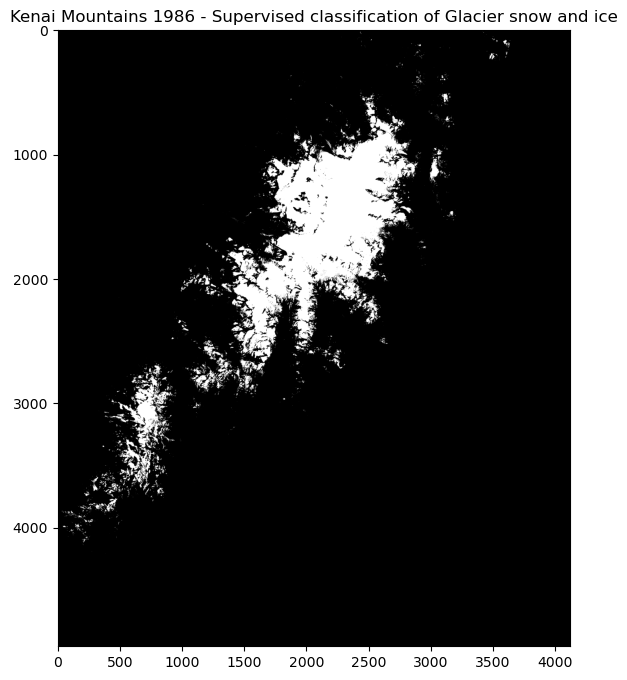

In [54]:
# Open the Trim TIF
with rasterio.open('KenaiMountains/1986Data/KM1986_FCC_Trim.TIF') as KM1986FCCsrc:
    # Read and load the bands from the False colour composite image
    KM1986_Normalised = KM1986FCCsrc.read()
    # Store the essential metadata
    KM1986_profile = KM1986FCCsrc.profile

# The Landsat bands are Digitial Numbers so we then will normalize bands from 0-255 (as they are an 8-bit image) to 0-1
KM1986_Normalised = KM1986_Normalised.astype(np.float32)
KM1986_Normalised /= KM1986_Normalised.max()

# Define the glacier mask to highlight all features in the image that have the set reflectance values in each respective band
KM1986_Glacier = (KM1986_Normalised[0] > 0.3) & (KM1986_Normalised[1] > 0.3) & (KM1986_Normalised[2] > 0.3)

# Redfine the glacier mask so it can be saved as new tif
KM1986_Glacier = KM1986_Glacier.astype(np.uint8)

# Update the glacier mask profile so that it only contains 1 band
KM1986_NewProfile = KM1986Trim_profile.copy()
KM1986_NewProfile.update(dtype='uint8', count=1)

# Save the glacier mask to the 1986Data file
with rasterio.open('KenaiMountains/1986Data/KM1986_GlacierMask.TIF', 'w', **KM1986_NewProfile) as dst:
    dst.write(KM1986_Glacier, 1)

# Display the glacier mask
plt.figure(figsize=(8, 8))
plt.imshow(KM1986_Glacier, cmap='gray') # Display the glacier mask as a greyscale map
plt.title('Kenai Mountains 1986 - Supervised classification of Glacier snow and ice')
plt.show()

In [51]:
# Open the cropped Glacier mask produced in the above step
with rasterio.open('KenaiMountains/1986Data/KM1986_GlacierMask.TIF') as KM1986GlacAreasrc:
    KM1986_GlacierMask = KM1986GlacAreasrc.read(1)  # Read first band
    transform = KM1986GlacAreasrc.transform
    GlacPixelWidth = transform[0]     # pixel width
    GlacPixelHeight = -transform[4]    # pixel height (The value is negative so we add an "-" to make it positive)

# Calculate the Area per Pixel for the image
KM1986_AreaPP = GlacPixelWidth * GlacPixelHeight  # For Landsat TM it will be 30m x 30m 

# Calculate how many pixels in the image have been identified as snow as per the Glacier mask above
KM1986_GlacPixel = np.sum(KM1986_GlacierMask == 1)

# Calculate the estimated area coverage of Glacier Ice and snow
TotalGlacArea1986 = (KM1986_GlacPixel * KM1986_AreaPP) / 1e6  # convert to square kilometers

print(f"Estimated 1986 Glacier Area: {TotalGlacArea1986:.2f} km²")

Estimated 1986 Glacier Area: 1358.32 km²


## Downloading and analysing the 1995 Landsat Scene ##

In [ ]:
# In this cell we will use the search function to get the product id of the imager used in the study
results_1995 = api.scene_search(
    dataset = "landsat_tm_c2_l1", #Landsat dataset used for 1986 image
    lat = 60.12735, # The latitude of the image
    lng = -151.22005, # The longtitude of the image
    start_date = "1995-08-19", # The start date of the search range
    end_date = "1995-08-21", # The end date of the search range
    api_key=api_key # The Users Api key
)
#The next lines of script will loop through each 'scene' that appears in the results and will print out the 'entity ID' which will be used in the dataset downlaod.
for scene in results_1995['data']['results']:
    print("The Entity ID of the Landsat scene is",(scene['entityId'])) 

In [ ]:
# The below code will download the Landsat Satellite images which we identified in the Scene Search above
# We will use the OS module to create a new folder for the Landsat images to be downloaded into
# The download url returned in the download_request will be used via the requests module
# The images will downloaded as a tar file as this file type is supported by the api

os.makedirs("KenaiMountains1995", exist_ok=True) # This will create a new folder for the Kenai Mountains 1986 images

KM_1995 = api.download_request( # This functions will return the available download urls for the Landsat scene
    dataset="landsat_tm_c2_l1", # Landsat dataset
    entity_id="LT50690181995232XXX01", # Landsat scene ID
    product_id="5e83d0a0f94d7d8d", # Product ID (Landsat Band file), this will be the same the 1986 dataset as it also using Landsat TM
)

 # The below code will download the Landsat data using the url provided by the download_request function from the EE node
if 'data' in KM_1995 and 'availableDownloads' in KM_1995['data']:
    KM_1995Avail = KM_1995['data']['availableDownloads'] # Identifies if the above Landsat is available to be downloaded
    if KM_1995Avail:
        KM1995downloadurl = KM_1995Avail[0]['url'] # We access the first download url retrieved from download_request
        KM_1995File = os.path.join("KenaiMountains1995", f"LT50690181995232XXX01.tar") # We set a file pathway for the download into the new Kenai Mountains 1986 folder created above
        KM1995url = requests.get(KM1995downloadurl, stream=True) # We use the requests module to request the url stored in the 'KM1986downloadurl' variable
        
        with open(KM_1995File, "wb") as f: # We are telling the code to overwrite or create the file and write it in binary mode to avoid corruption as we are downloading images
            for chunk in KM1995url.iter_content(chunk_size=8192): # To avoid causing issues downloading larger sets of data we download the folder in 8 KB Chunks
                if chunk:
                    f.write(chunk)

# The download may take some time but you will see the download progress in the newly creaated 'KenaiMountains1986' folder (click refresh on the folder)
print("1995 Kenai Mountain images downloaded!") # The text will display whenever the download has been completed

In [ ]:
# We will extract the Landsat images from the scene we have just downloaded into the same folder
with tarfile.open("KenaiMountains1995/LT50690181995232XXX01.tar", 'r') as KM1986Tar:
    KM1986Tar.extractall("KenaiMountains1995")

print("Images have been successfully extracted")

In [ ]:
# In this cell we will build the False Colour Composite image of the 1986 Landsat scene
# The bands we are going to need are B4, B3 and B2 (NIR, Red and Green respectively)
# After we build the Landsat scene we are going to save the new image to the 'KenaiMountains1986' folder

#First we are going to use the rasterio module to open the paths to the Band TIF files in the folder they are saved to
with rasterio.open("KenaiMountains1995/LT05_L1TP_069018_19950820_20200912_02_T1_B4.TIF") as KM1995_B4IMG:
    KM95B4 = KM1995_B4IMG.read(1)
with rasterio.open("KenaiMountains1995/LT05_L1TP_069018_19950820_20200912_02_T1_B3.TIF") as KM1995_B3IMG:
    KM95B3 = KM1995_B3IMG.read(1)
with rasterio.open("KenaiMountains1995/LT05_L1TP_069018_19950820_20200912_02_T1_B2.TIF") as KM1995_B2IMG:
    KM95B2 = KM1995_B2IMG.read(1)

# We will stack the newly defined bands using the NumPy module to create a single 3D Array
KM1995_falsecolourstack = np.dstack((KM95B4, KM95B3, KM95B2))

# Then the created 3D array will be printed to show the False Colour Composite image of the selected Landsat scene for 1986
plt.figure(figsize=(8, 8))
plt.imshow(KM1995_falsecolourstack)
plt.title("Kenai Mountains 1995 False Colour Composite Image")
plt.show()

In [ ]:
# Now that the False Colour Composite Image has been created, we will need to save the image  

# First we will open one of the bands to get its profile and use it as a source
with rasterio.open("KenaiMountains1995/LT05_L1TP_069018_19950820_20200912_02_T1_B4.TIF") as KM1995_source:
    KM1995_ImgProfile = KM1995_source.profile

# We then update the profile for all of the bands in the False Colour Composite using the source
KM1995_ImgProfile.update(
    count=3,  # The count is set to 3 as we are using 3 bands (NIR, Red and Green)
    dtype=KM1995_falsecolourstack.dtype  # We set that data type to be the same as the created False Colour Composite
)

# Finally we save the False Colour Composite to the Kenai Mountains folder
with rasterio.open('KenaiMountains1995/KM1995_FullFCC.TIF', 'w', **KM1995_ImgProfile) as KM1995_FCCdownload:
# We then use the .write function to save the False Colour image to the Kenai Mountains 1986 folder
    
# We use .transpose to chnage the shape of the array to match the format expected by rasterio when writing/saving the image to the folder (Bands, Rows and Columns respectively) 
    KM1995_FCCdownload.write(KM1995_falsecolourstack.transpose(2, 0, 1))  
print("Image has been saved as KM1995_FullFCC.TIF in KenaiMountains1995")

In [ ]:
# The KenaiMountains1986 folder is rather full and messy so we will delete all the unneccessary files that we no longer need
# The only file we need from here on is the exported False Colour Composite so the rest can be deleted to make the GitHub commits easier
# This will be useful when it comes to using more modern Landsat datasets as the files will be over 100mb which causes issues in the GitHub commit

for KM1995_filenames in os.listdir('KenaiMountains1995'): 
    KM1995_FilePath = os.path.join('KenaiMountains1995', KM1995_filenames) # We create a variable that loops through all of the filenames in the KenaiMountains1986 folder
    
    if os.path.isfile(KM1995_FilePath) and KM1995_filenames != 'KM1995_FullFCC.TIF':
        os.remove(KM1995_FilePath)
print("Deleted the files that are no longer required (Click Refresh on folder)")

In [ ]:
with rasterio.open('KenaiMountains1995/KM1995_FullFCC.TIF') as KM1995FCCsrc:
    print(KM1995FCCsrc.bounds)

In [ ]:
# In order to crop the TIF we are going ot define a new bounding box to highlight only the Kenai Mountains in the Image
BoundingBox = {"left": 601185.0,"bottom": 6551985.0,"right": 734815.0,"top": 6700615.0}

# Open source raster for the crop
with rasterio.open('KenaiMountains1995/KM1995_FullFCC.TIF') as KM1995Cropsrc:
    # We then define a crop window using the bounding box above
    KM1995Trim = from_bounds(BoundingBox["left"], BoundingBox["bottom"], BoundingBox["right"], BoundingBox["top"], transform=KM1986Cropsrc.transform)
    
    # Read data within the created boudning box window
    KM1995Trim_Data = KM1995Cropsrc.read(window=KM1995Trim)
    
    # Update the profile of the new trimmed image so that it can be saved and used in the data analysis
    KM1995Trim_Transform = KM1995Cropsrc.window_transform(KM1995Trim)
    KM1995Trim_profile = KM1995Cropsrc.profile.copy()
    KM1995Trim_profile.update({
        "height": KM1995Trim_Data.shape[1],
        "width": KM1995Trim_Data.shape[2],
        "transform": KM1995Trim_Transform
    })

# Save the cropped image and metadata to a new TIF
with rasterio.open('KenaiMountains1995/KM1995_FCC_Trim.TIF', "w", **KM1995Trim_profile) as dst:
    dst.write(KM1995Trim_Data)

# Display the trim so that we can be satisfied that the study area is covered
plt.imshow(KM1995Trim_Data.transpose((1, 2, 0)))
plt.title("Cropped 1995 Kenai Mountains Image")
plt.show()

In [ ]:
#First we will open the TIF
with rasterio.open('KenaiMountains1995/KM1995_FCC_Trim.TIF') as KM1995FCCsrc:
    KM1995_Normalised = KM1995FCCsrc.read()
    KM1995_profile = KM1995FCCsrc.profile

# The Landsat bands are Digitial Numbers so we then will normalize bands from 0-255 (as they are an 8-bit image) to 0-1
KM1995_Normalised = KM1995_Normalised.astype(np.float32)
KM1995_Normalised /= KM1995_Normalised.max()


KM1995_Glacier = (KM1995_Normalised[0] > 0.2) & (KM1995_Normalised[1] > 0.2) & (KM1995_Normalised[2] > 0.3)

# We the redefine the new cropped pxiel based classification before we calculate the area
# This will save the mask produced by the above code to a new TIF which we will use to calculate the area of Glacier snow and ice
KM1995_Glacier = KM1995_Glacier.astype(np.uint8)

KM1995_NewProfile = KM1995_profile.copy()
KM1995_NewProfile.update(dtype='uint8', count=1)

with rasterio.open('KenaiMountains1995/KM1995_GlacierMask.TIF', 'w', **KM1995_NewProfile) as dst:
    dst.write(KM1995_Glacier, 1)

plt.figure(figsize=(8, 8))
plt.imshow(KM1995_Glacier, cmap='gray')
plt.title('Kenai Mountains 1995 - Pixel Based of Glacier snow and ice')
plt.show()

In [ ]:
# Open the cropped Glacier mask produced in the above step
with rasterio.open('KenaiMountains1995/KM1995_GlacierMask.TIF') as KM1995GlacAreasrc:
    KM1995_GlacierMask = KM1995GlacAreasrc.read(1)  # Read first band of the Glacier Mask
    KM1995_Transfrom = KM1995GlacAreasrc.transform
    GlacPixelWidth = KM1995_Transfrom[0]     # pixel width
    GlacPixelHeight = -KM1995_Transfrom[4]    # pixel height (The value is negative so we add an "-" to make it positive)

# Calculate the Area per Pixel for the image
KM1995_AreaPP = GlacPixelWidth * GlacPixelHeight  # For Landsat TM it will be 30m x 30m 

# Calculate how many pixels in the image have been identified as snow as per the Glacier mask above
KM1995_GlacPixel = np.sum(KM1995_GlacierMask == 1)

# Calculate the estimated area coverage of Glacier Ice and snow
TotalGlacArea1995 = (KM1995_GlacPixel * KM1995_AreaPP) / 1e6  # convert to square kilometers

print(f"Estimated 1995 Glacier Area: {TotalGlacArea1995:.2f} km²")

## Downloading and analysing the 2009 Landsat Scene ##

In [ ]:
# In this cell we will use the search function to get the product id of the imager used in the study
results_2009 = api.scene_search(
    dataset = "landsat_tm_c2_l1", #Landsat dataset used for 1986 image
    lat = 60.09405, # The latitude of the image
    lng = -150.98167, # The longtitude of the image
    start_date = "2009-07-08", # The start date of the search range
    end_date = "2009-07-09", # The end date of the search range
    api_key=api_key # The Users Api key
)
#The next lines of script will loop through each 'scene' that appears in the results and will print out the 'entity ID' which will be used in the dataset downlaod.
for scene in results_2009['data']['results']:
    print("The Entity ID of the Landsat scene is",(scene['entityId'])) 

In [ ]:
# The below code will download the Landsat Satellite images which we identified in the Scene Search above
# We will use the OS module to create a new folder for the Landsat images to be downloaded into
# The download url returned in the download_request will be used via the requests module
# The images will downloaded as a tar file as this file type is supported by the api

os.makedirs("KenaiMountains2009", exist_ok=True) # This will create a new folder for the Kenai Mountains 1986 images

KM_2009 = api.download_request( # This functions will return the available download urls for the Landsat scene
    dataset="landsat_tm_c2_l1", # Landsat dataset
    entity_id="LT50690182009190GLC00", # Landsat scene ID
    product_id="5e83d0a0f94d7d8d", # Product ID (Landsat Band file), this will be the same the 1986 dataset as it also using Landsat TM
)

 # The below code will download the Landsat data using the url provided by the download_request function from the EE node
if 'data' in KM_2009 and 'availableDownloads' in KM_2009['data']:
    KM_2009Avail = KM_2009['data']['availableDownloads'] # Identifies if the above Landsat is available to be downloaded
    if KM_2009Avail:
        KM2009downloadurl = KM_2009Avail[0]['url'] # We access the first download url retrieved from download_request
        KM_2009File = os.path.join("KenaiMountains2009", f"LT50690182009190GLC00.tar") # We set a file pathway for the download into the new Kenai Mountains 1986 folder created above
        KM2009url = requests.get(KM2009downloadurl, stream=True) # We use the requests module to request the url stored in the 'KM1986downloadurl' variable
        
        with open(KM_2009File, "wb") as f: # We are telling the code to overwrite or create the file and write it in binary mode to avoid corruption as we are downloading images
            for chunk in KM2009url.iter_content(chunk_size=8192): # To avoid causing issues downloading larger sets of data we download the folder in 8 KB Chunks
                if chunk:
                    f.write(chunk)

# The download may take some time but you will see the download progress in the newly creaated 'KenaiMountains1986' folder (click refresh on the folder)
print("2009 Kenai Mountain images downloaded!") # The text will display whenever the download has been completed

In [ ]:
# We will extract the Landsat images from the scene we have just downloaded into the same folder
with tarfile.open("KenaiMountains2009/LT50690182009190GLC00.tar", 'r') as KM2009Tar:
    KM2009Tar.extractall("KenaiMountains2009")

print("Images have been successfully extracted")

In [ ]:
# In this cell we will build the False Colour Composite image of the 1986 Landsat scene
# The bands we are going to need are B4, B3 and B2 (NIR, Red and Green respectively)
# After we build the Landsat scene we are going to save the new image to the 'KenaiMountains1986' folder

#First we are going to use the rasterio module to open the paths to the Band TIF files in the folder they are saved to
with rasterio.open("KenaiMountains2009/LT05_L1TP_069018_20090709_20200827_02_T1_B4.TIF") as KM2009_B4IMG:
    KM09B4 = KM2009_B4IMG.read(1)
with rasterio.open("KenaiMountains2009/LT05_L1TP_069018_20090709_20200827_02_T1_B3.TIF") as KM2009_B3IMG:
    KM09B3 = KM2009_B3IMG.read(1)
with rasterio.open("KenaiMountains2009/LT05_L1TP_069018_20090709_20200827_02_T1_B2.TIF") as KM2009_B2IMG:
    KM09B2 = KM2009_B2IMG.read(1)

# We will stack the newly defined bands using the NumPy module to create a single 3D Array
KM2009_falsecolourstack = np.dstack((KM09B4, KM09B3, KM09B2))

# Then the created 3D array will be printed to show the False Colour Composite image of the selected Landsat scene for 1986
plt.figure(figsize=(8, 8))
plt.imshow(KM2009_falsecolourstack)
plt.title("Kenai Mountains 2009 False Colour Composite Image")
plt.show()

In [ ]:
# Now that the False Colour Composite Image has been created, we will need to save the image  

# First we will open one of the bands to get its profile and use it as a source
with rasterio.open("KenaiMountains2009/LT05_L1TP_069018_20090709_20200827_02_T1_B4.TIF") as KM2009_source:
    KM2009_ImgProfile = KM2009_source.profile

# We then update the profile for all of the bands in the False Colour Composite using the source
KM2009_ImgProfile.update(
    count=3,  # The count is set to 3 as we are using 3 bands (NIR, Red and Green)
    dtype=KM2009_falsecolourstack.dtype  # We set that data type to be the same as the created False Colour Composite
)

# Finally we save the False Colour Composite to the Kenai Mountains folder
with rasterio.open('KenaiMountains2009/KM2009_FullFCC.TIF', 'w', **KM2009_ImgProfile) as KM2009_FCCdownload:
# We then use the .write function to save the False Colour image to the Kenai Mountains 2009 folder
    
# We use .transpose to chnage the shape of the array to match the format expected by rasterio when writing/saving the image to the folder (Bands, Rows and Columns respectively) 
    KM2009_FCCdownload.write(KM2009_falsecolourstack.transpose(2, 0, 1))  
print("Image has been saved as KM2009_FullFCC.TIF in KenaiMountains1995")

In [ ]:
# The KenaiMountains1986 folder is rather full and messy so we will delete all the unneccessary files that we no longer need
# The only file we need from here on is the exported False Colour Composite so the rest can be deleted to make the GitHub commits easier
# This will be useful when it comes to using more modern Landsat datasets as the files will be over 100mb which causes issues in the GitHub commit

for KM2009_filenames in os.listdir('KenaiMountains2009'): 
    KM2009_FilePath = os.path.join('KenaiMountains2009', KM2009_filenames) # We create a variable that loops through all of the filenames in the KenaiMountains1986 folder
    
    if os.path.isfile(KM2009_FilePath) and KM2009_filenames != 'KM2009_FullFCC.TIF':
        os.remove(KM2009_FilePath)
print("Deleted the files that are no longer required (Click Refresh on folder)")

In [ ]:
with rasterio.open('KenaiMountains2009/KM2009_FullFCC.TIF') as KM2009FCCsrc:
    print(KM2009FCCsrc.bounds)

In [ ]:
### ADJUST BOUNDING BOX DIMENSIONS ####


# In order to crop the TIF we are going ot define a new bounding box to highlight only the Kenai Mountains in the Image
BoundingBox = {"left": 601185.0,"bottom": 6551985.0,"right": 734815.0,"top": 6700615.0}

# Open source raster for the crop
with rasterio.open('KenaiMountains2009/KM2009_FullFCC.TIF') as KM2009Cropsrc:
    # We then define a crop window using the bounding box above
    KM2009Trim = from_bounds(BoundingBox["left"], BoundingBox["bottom"], BoundingBox["right"], BoundingBox["top"], transform=KM1986Cropsrc.transform)
    
    # Read data within the created boudning box window
    KM2009Trim_Data = KM2009Cropsrc.read(window=KM2009Trim)
    
    # Update the profile of the new trimmed image so that it can be saved and used in the data analysis
    KM2009Trim_Transform = KM2009Cropsrc.window_transform(KM2009Trim)
    KM2009Trim_profile = KM2009Cropsrc.profile.copy()
    KM2009Trim_profile.update({
        "height": KM2009Trim_Data.shape[1],
        "width": KM2009Trim_Data.shape[2],
        "transform": KM2009Trim_Transform
    })

# Save the cropped image and metadata to a new TIF
with rasterio.open('KenaiMountains2009/KM2009_FCC_Trim.TIF', "w", **KM2009Trim_profile) as dst:
    dst.write(KM2009Trim_Data)

# Display the trim so that we can be satisfied that the study area is covered
plt.imshow(KM2009Trim_Data.transpose((1, 2, 0)))
plt.title("Cropped 2009 Kenai Mountains Image")
plt.show()

In [ ]:
#First we will open the TIF
with rasterio.open('KenaiMountains2009/KM2009_FCC_Trim.TIF') as KM2009FCCsrc:
    KM2009_Normalised = KM2009FCCsrc.read()
    KM2009_profile = KM2009FCCsrc.profile

# The Landsat bands are Digitial Numbers so we then will normalize bands from 0-255 (as they are an 8-bit image) to 0-1
KM2009_Normalised = KM2009_Normalised.astype(np.float32)
KM2009_Normalised /= KM2009_Normalised.max()


KM2009_Glacier = (KM2009_Normalised[0] > 0.2) & (KM2009_Normalised[1] > 0.2) & (KM2009_Normalised[2] > 0.3)

# We the redefine the new cropped pxiel based classification before we calculate the area
# This will save the mask produced by the above code to a new TIF which we will use to calculate the area of Glacier snow and ice
KM2009_Glacier = KM2009_Glacier.astype(np.uint8)

KM2009_NewProfile = KM2009_profile.copy()
KM2009_NewProfile.update(dtype='uint8', count=1)

with rasterio.open('KenaiMountains2009/KM2009_GlacierMask.TIF', 'w', **KM2009_NewProfile) as dst:
    dst.write(KM2009_Glacier, 1)

plt.figure(figsize=(8, 8))
plt.imshow(KM2009_Glacier, cmap='gray')
plt.title('Kenai Mountains 2009 - Pixel Based of Glacier snow and ice')
plt.show()

In [ ]:
# Open the cropped Glacier mask produced in the above step
with rasterio.open('KenaiMountains2009/KM2009_GlacierMask.TIF') as KM2009GlacAreasrc:
    KM2009_GlacierMask = KM2009GlacAreasrc.read(1)  # Read first band of the Glacier Mask
    KM2009_Transfrom = KM2009GlacAreasrc.transform
    GlacPixelWidth = KM2009_Transfrom[0]     # pixel width
    GlacPixelHeight = -KM2009_Transfrom[4]    # pixel height (The value is negative so we add an "-" to make it positive)

# Calculate the Area per Pixel for the image
KM2009_AreaPP = GlacPixelWidth * GlacPixelHeight  # For Landsat TM it will be 30m x 30m 

# Calculate how many pixels in the image have been identified as snow as per the Glacier mask above
KM2009_GlacPixel = np.sum(KM2009_GlacierMask == 1)

# Calculate the estimated area coverage of Glacier Ice and snow
TotalGlacArea2009 = (KM2009_GlacPixel * KM2009_AreaPP) / 1e6  # convert to square kilometers

print(f"Estimated 2009 Glacier Area: {TotalGlacArea1995:.2f} km²")

## Downloading and analysing the 2014 Landsat Scene ##

In [ ]:
# In this cell we will use the search function to get the product id of the imager used in the study
results_2014 = api.scene_search(
    dataset = "landsat_ot_c2_l1", #Landsat dataset used for 1986 image
    lat = 60.09334, # The latitude of the image
    lng = -150.97721, # The longtitude of the image
    start_date = "2014-09-24", # The start date of the search range
    end_date = "2014-09-26", # The end date of the search range
    api_key=api_key # The Users Api key
)
#The next lines of script will loop through each 'scene' that appears in the results and will print out the 'entity ID' which will be used in the dataset downlaod.
for scene in results_2014['data']['results']:
    print("The Entity ID of the Landsat scene is",(scene['entityId'])) 

The download for the Landsat 8 image will take a few minutes to download as the image folder and contains larger images. 

In [ ]:
# The below code will download the Landsat Satellite images which we identified in the Scene Search above
# We will use the OS module to create a new folder for the Landsat images to be downloaded into
# The download url returned in the download_request will be used via the requests module
# The images will downloaded as a tar file as this file type is supported by the api

os.makedirs("KenaiMountains2014", exist_ok=True) # This will create a new folder for the Kenai Mountains 1986 images

KM_2014 = api.download_request( # This functions will return the available download urls for the Landsat scene
    dataset="landsat_ot_c2_l1", # Landsat dataset
    entity_id="LC80690182014268LGN01", # Landsat scene ID
    product_id="5e81f14f92acf9ef", # Product ID (Landsat Band file), this will be the same the 1986 dataset as it also using Landsat TM
)

 # The below code will download the Landsat data using the url provided by the download_request function from the EE node
if 'data' in KM_2014 and 'availableDownloads' in KM_2014['data']:
    KM_2014Avail = KM_2014['data']['availableDownloads'] # Identifies if the above Landsat is available to be downloaded
    if KM_2014Avail:
        KM2014downloadurl = KM_2014Avail[0]['url'] # We access the first download url retrieved from download_request
        KM_2014File = os.path.join("KenaiMountains2014", f"LC80690182014268LGN01.tar") # We set a file pathway for the download into the new Kenai Mountains 1986 folder created above
        KM2014url = requests.get(KM2014downloadurl, stream=True) # We use the requests module to request the url stored in the 'KM1986downloadurl' variable
        
        with open(KM_2014File, "wb") as f: # We are telling the code to overwrite or create the file and write it in binary mode to avoid corruption as we are downloading images
            for chunk in KM2014url.iter_content(chunk_size=8192): # To avoid causing issues downloading larger sets of data we download the folder in 8 KB Chunks
                if chunk:
                    f.write(chunk)

# The download may take some time but you will see the download progress in the newly creaated 'KenaiMountains2009' folder (click refresh on the folder)
print("2014 Kenai Mountain images downloaded!") 

In [ ]:
# We will extract the Landsat images from the scene we have just downloaded into the same folder
with tarfile.open('KenaiMountains2014/LC80690182014268LGN01.tar', 'r') as KM2014Tar:
    KM2014Tar.extractall('KenaiMountains2014')

print("Images have been successfully extracted")

In [ ]:
# In this cell we will build the False Colour Composite image of the 1986 Landsat scene
# The bands we are going to need are B4, B3 and B2 (NIR, Red and Green respectively)
# After we build the Landsat scene we are going to save the new image to the 'KenaiMountains1986' folder

#First we are going to use the rasterio module to open the paths to the Band TIF files in the folder they are saved to
with rasterio.open('KenaiMountains2014/LC08_L1TP_069018_20140925_20200910_02_T1_B5.TIF') as KM2014_B5IMG:
    KM14B5 = KM2014_B5IMG.read(1)
with rasterio.open('KenaiMountains2014/LC08_L1TP_069018_20140925_20200910_02_T1_B4.TIF') as KM2014_B4IMG:
    KM14B4 = KM2014_B4IMG.read(1)
with rasterio.open('KenaiMountains2014/LC08_L1TP_069018_20140925_20200910_02_T1_B3.TIF') as KM2014_B3IMG:
    KM14B3 = KM2014_B3IMG.read(1)

# We will stack the newly defined bands using the NumPy module to create a single 3D Array
KM2014_falsecolourstack = np.dstack((KM14B5, KM14B4, KM14B3))

KM2014_Normalised = KM2014_falsecolourstack.astype(np.float32)
KM2014_Normalised /= KM2014_Normalised.max()

# Then the created 3D array will be printed to show the False Colour Composite image of the selected Landsat scene for 1986
plt.figure(figsize=(8, 8))
plt.imshow(KM2014_Normalised)
plt.title("Kenai Mountains 2014 False Colour Composite Image")
plt.show()

In [ ]:
# Now that the False Colour Composite Image has been created, we will need to save the image  

# First we will open one of the bands to get its profile and use it as a source
with rasterio.open('KenaiMountains2014/LC08_L1TP_069018_20140925_20200910_02_T1_B5.TIF') as KM2014_source:
    KM2014_ImgProfile = KM2014_source.profile

# We then update the profile for all of the bands in the False Colour Composite using the source
KM2014_ImgProfile.update(
    count=3,  # The count is set to 3 as we are using 3 bands (NIR, Red and Green)
    dtype=KM2014_Normalised.dtype  # We set that data type to be the same as the created False Colour Composite
)

# Finally we save the False Colour Composite to the Kenai Mountains folder
with rasterio.open('KenaiMountains2014/KM2014_FullFCC.TIF', 'w', **KM2014_ImgProfile) as KM2014_FCCdownload:
# We then use the .write function to save the False Colour image to the Kenai Mountains 2009 folder
    
# We use .transpose to chnage the shape of the array to match the format expected by rasterio when writing/saving the image to the folder (Bands, Rows and Columns respectively) 
    KM2014_FCCdownload.write(KM2014_Normalised.transpose(2, 0, 1))  
print("Image has been saved as KM2014_FullFCC.TIF in KenaiMountain2014")

In [ ]:
with rasterio.open('KenaiMountains2014/KM2014_FullFCC.TIF') as KM2014FCCsrc:
    print(KM2014FCCsrc.bounds)

In [ ]:
### ADJUST BOUNDING BOX DIMENSIONS ####


# In order to crop the TIF we are going ot define a new bounding box to highlight only the Kenai Mountains in the Image
BoundingBox = {"left": 601185.0,"bottom": 6551985.0,"right": 724815.0,"top": 6700615.0}

# Open source raster for the crop
with rasterio.open('KenaiMountains2014/KM2014_FullFCC.TIF') as KM2014Cropsrc:
    # We then define a crop window using the bounding box above
    KM2014Trim = from_bounds(BoundingBox["left"], BoundingBox["bottom"], BoundingBox["right"], BoundingBox["top"], transform=KM2014Cropsrc.transform)
    
    # Read data within the created boudning box window
    KM2014Trim_Data = KM2014Cropsrc.read(window=KM2014Trim)
    
    # Update the profile of the new trimmed image so that it can be saved and used in the data analysis
    KM2014Trim_Transform = KM2014Cropsrc.window_transform(KM2014Trim)
    KM2014Trim_profile = KM2014Cropsrc.profile.copy()
    KM2014Trim_profile.update({
        "height": KM2014Trim_Data.shape[1],
        "width": KM2014Trim_Data.shape[2],
        "transform": KM2014Trim_Transform
    })

# Save the cropped image and metadata to a new TIF
with rasterio.open('KenaiMountains2014/KM2014_FCC_Trim.TIF', "w", **KM2014Trim_profile) as dst:
    dst.write(KM2014Trim_Data)

# Display the trim so that we can be satisfied that the study area is covered
plt.imshow(KM2014Trim_Data.transpose((1, 2, 0)))
plt.title("Cropped 2014 Kenai Mountains Image")
plt.show()

In [ ]:
# The KenaiMountains1986 folder is rather full and messy so we will delete all the unneccessary files that we no longer need
# The only file we need from here on is the exported False Colour Composite so the rest can be deleted to make the GitHub commits easier
# This will be useful when it comes to using more modern Landsat datasets as the files will be over 100mb which causes issues in the GitHub commit

for KM2014_filenames in os.listdir('KenaiMountains2014'): 
    KM2014_FilePath = os.path.join('KenaiMountains2014', KM2014_filenames) # We create a variable that loops through all of the filenames in the KenaiMountains1986 folder
    
    if os.path.isfile(KM2014_FilePath) and KM2014_filenames !='KM2014_FCC_Trim.TIF':
        os.remove(KM2014_FilePath)
print("Deleted the files that are no longer required (Click Refresh on folder)")

In [ ]:
#First we will open the TIF
with rasterio.open('KenaiMountains2014/KM2014_FCC_Trim.TIF') as KM2014FCCsrc:
    KM2014_Normalised = KM2014FCCsrc.read()
    KM2014_profile = KM2014FCCsrc.profile

# The Landsat bands are Digitial Numbers so we then will normalize bands from 0-255 (as they are an 8-bit image) to 0-1
KM2014_Normalised = KM2014_Normalised.astype(np.float32)
KM2014_Normalised /= KM2014_Normalised.max()


KM2014_Glacier = (KM2014_Normalised[0] > 0.3) & (KM2014_Normalised[1] > 0.3) & (KM2014_Normalised[2] > 0.3)

# We the redefine the new cropped pxiel based classification before we calculate the area
# This will save the mask produced by the above code to a new TIF which we will use to calculate the area of Glacier snow and ice
KM2014_Glacier = KM2014_Glacier.astype(np.uint8)

KM2014_NewProfile = KM2014_profile.copy()
KM2014_NewProfile.update(dtype='uint8', count=1)

with rasterio.open('KenaiMountains2014/KM2014_GlacierMask.TIF', 'w', **KM2014_NewProfile) as dst:
    dst.write(KM2014_Glacier, 1)

plt.figure(figsize=(8, 8))
plt.imshow(KM2014_Glacier, cmap='gray')
plt.title('Kenai Mountains 2014 - Pixel Based of Glacier snow and ice')
plt.show()

In [ ]:
# Open the cropped Glacier mask produced in the above step
with rasterio.open('KenaiMountains2014/KM2014_GlacierMask.TIF') as KM2014GlacAreasrc:
    KM2014_GlacierMask = KM2014GlacAreasrc.read(1)  # Read first band of the Glacier Mask
    KM2014_Transfrom = KM2014GlacAreasrc.transform
    GlacPixelWidth = KM2014_Transfrom[0]     # pixel width
    GlacPixelHeight = -KM2014_Transfrom[4]    # pixel height (The value is negative so we add an "-" to make it positive)

# Calculate the Area per Pixel for the image
KM2014_AreaPP = GlacPixelWidth * GlacPixelHeight  # For Landsat TM it will be 30m x 30m 

# Calculate how many pixels in the image have been identified as snow as per the Glacier mask above
KM2014_GlacPixel = np.sum(KM2014_GlacierMask == 1)

# Calculate the estimated area coverage of Glacier Ice and snow
TotalGlacArea2014 = (KM2014_GlacPixel * KM2014_AreaPP) / 1e6  # convert to square kilometers

print(f"Estimated 2014 Glacier Area: {TotalGlacArea2014:.2f} km²")

## Downloading and analysing the 2014 Landsat Scene ##

In [ ]:
# In this cell we will use the search function to get the product id of the imager used in the study
results_2024 = api.scene_search(
    dataset = "landsat_ot_c2_l1", #Landsat dataset used for 1986 image
    lat = 60.09328, # The latitude of the image
    lng = -149.48212, # The longtitude of the image
    start_date = "2024-08-20", # The start date of the search range
    end_date = "2024-08-20", # The end date of the search range
    api_key=api_key # The Users Api key
)
#The next lines of script will loop through each 'scene' that appears in the results and will print out the 'entity ID' which will be used in the dataset downlaod.
for scene in results_2024['data']['results']:
    print("The Entity ID of the Landsat scene is",(scene['entityId'])) 

In [ ]:
# The below code will download the Landsat Satellite images which we identified in the Scene Search above
# We will use the OS module to create a new folder for the Landsat images to be downloaded into
# The download url returned in the download_request will be used via the requests module
# The images will downloaded as a tar file as this file type is supported by the api

os.makedirs("KenaiMountains2024", exist_ok=True) # This will create a new folder for the Kenai Mountains 1986 images

KM_2024 = api.download_request( # This functions will return the available download urls for the Landsat scene
    dataset="landsat_ot_c2_l1", # Landsat dataset
    entity_id="LC90680182024233LGN00", # Landsat scene ID
    product_id="5e81f14f92acf9ef", # Product ID (Landsat Band file), this will be the same the 2017 dataset as it also using Landsat OT
)

 # The below code will download the Landsat data using the url provided by the download_request function from the EE node
if 'data' in KM_2024 and 'availableDownloads' in KM_2024['data']:
    KM_2024Avail = KM_2024['data']['availableDownloads'] # Identifies if the above Landsat is available to be downloaded
    if KM_2024Avail:
        KM2024downloadurl = KM_2024Avail[0]['url'] # We access the first download url retrieved from download_request
        KM_2024File = os.path.join("KenaiMountains2024", f"LC90680182024233LGN00.tar") # We set a file pathway for the download into the new Kenai Mountains 1986 folder created above
        KM2024url = requests.get(KM2024downloadurl, stream=True) # We use the requests module to request the url stored in the 'KM1986downloadurl' variable
        
        with open(KM_2024File, "wb") as f: # We are telling the code to overwrite or create the file and write it in binary mode to avoid corruption as we are downloading images
            for chunk in KM2024url.iter_content(chunk_size=8192): # To avoid causing issues downloading larger sets of data we download the folder in 8 KB Chunks
                if chunk:
                    f.write(chunk)

# The download may take some time but you will see the download progress in the newly creaated 'KenaiMountains2009' folder (click refresh on the folder)
print("2024 Kenai Mountain images downloaded!") 

In [ ]:
# We will extract the Landsat images from the scene we have just downloaded into the same folder
with tarfile.open('KenaiMountains2024/LC90680182024233LGN00.tar', 'r') as KM2024Tar:
    KM2024Tar.extractall('KenaiMountains2024')

print("Images have been successfully extracted")

In [ ]:
# In this cell we will build the False Colour Composite image of the 1986 Landsat scene
# The bands we are going to need are B4, B3 and B2 (NIR, Red and Green respectively)
# After we build the Landsat scene we are going to save the new image to the 'KenaiMountains1986' folder

#First we are going to use the rasterio module to open the paths to the Band TIF files in the folder they are saved to
with rasterio.open('KenaiMountains2024/LC09_L1TP_068018_20240820_20240820_02_T1_B5.TIF') as KM2024_B5IMG:
    KM24B5 = KM2024_B5IMG.read(1)
with rasterio.open('KenaiMountains2024/LC09_L1TP_068018_20240820_20240820_02_T1_B4.TIF') as KM2024_B4IMG:
    KM24B4 = KM2024_B4IMG.read(1)
with rasterio.open('KenaiMountains2024/LC09_L1TP_068018_20240820_20240820_02_T1_B3.TIF') as KM2024_B3IMG:
    KM24B3 = KM2024_B3IMG.read(1)

# We will stack the newly defined bands using the NumPy module to create a single 3D Array
KM2024_falsecolourstack = np.dstack((KM24B5, KM24B4, KM24B3))

KM2024_Normalised = KM2024_falsecolourstack.astype(np.float32)
KM2024_Normalised /= KM2024_Normalised.max()

# Then the created 3D array will be printed to show the False Colour Composite image of the selected Landsat scene for 1986
plt.figure(figsize=(8, 8))
plt.imshow(KM2024_Normalised)
plt.title("Kenai Mountains 2024 False Colour Composite Image")
plt.show()

In [ ]:
# Now that the False Colour Composite Image has been created, we will need to save the image  

# First we will open one of the bands to get its profile and use it as a source
with rasterio.open('KenaiMountains2024/LC09_L1TP_068018_20240820_20240820_02_T1_B5.TIF') as KM2024_source:
    KM2024_ImgProfile = KM2024_source.profile

# We then update the profile for all of the bands in the False Colour Composite using the source
KM2024_ImgProfile.update(
    count=3,  # The count is set to 3 as we are using 3 bands (NIR, Red and Green)
    dtype=KM2024_Normalised.dtype  # We set that data type to be the same as the created False Colour Composite
)

# Finally we save the False Colour Composite to the Kenai Mountains folder
with rasterio.open('KenaiMountains2024/KM2024_FullFCC.TIF', 'w', **KM2024_ImgProfile) as KM2024_FCCdownload:
# We then use the .write function to save the False Colour image to the Kenai Mountains 2009 folder
    
# We use .transpose to chnage the shape of the array to match the format expected by rasterio when writing/saving the image to the folder (Bands, Rows and Columns respectively) 
    KM2024_FCCdownload.write(KM2024_Normalised.transpose(2, 0, 1))  
print("Image has been saved as KM2024_FullFCC.TIF in KenaiMountain2014")

In [ ]:
with rasterio.open('KenaiMountains2024/KM2024_FullFCC.TIF') as KM2024FCCsrc:
    print(KM2024FCCsrc.bounds)

In [ ]:
print(KM2024Cropsrc.bounds)


In [ ]:
### ADJUST BOUNDING BOX DIMENSIONS ####


# In order to crop the TIF we are going ot define a new bounding box to highlight only the Kenai Mountains in the Image
BoundingBox = {"left": 181185.0,"bottom": 6551985.0,"right": 374815.0,"top": 6690615.0}

# Open source raster for the crop
with rasterio.open('KenaiMountains2024/KM2024_FullFCC.TIF') as KM2024Cropsrc:
    # We then define a crop window using the bounding box above
    KM2024Trim = from_bounds(BoundingBox["left"], BoundingBox["bottom"], BoundingBox["right"], BoundingBox["top"], transform=KM2024Cropsrc.transform)
    
    # Read data within the created boudning box window
    KM2024Trim_Data = KM2024Cropsrc.read(window=KM2024Trim)
    
    # Update the profile of the new trimmed image so that it can be saved and used in the data analysis
    KM2024Trim_Transform = KM2024Cropsrc.window_transform(KM2024Trim)
    KM2024Trim_profile = KM2024Cropsrc.profile.copy()
    KM2024Trim_profile.update({
        "height": KM2024Trim_Data.shape[1],
        "width": KM2024Trim_Data.shape[2],
        "transform": KM2024Trim_Transform
    })

# Save the cropped image and metadata to a new TIF
with rasterio.open('KenaiMountains2024/KM2024_FCC_Trim.TIF', "w", **KM2024Trim_profile) as dst:
    dst.write(KM2024Trim_Data)

# Display the trim so that we can be satisfied that the study area is covered
plt.imshow(KM2024Trim_Data.transpose((1, 2, 0)))
plt.title("Cropped 2024 Kenai Mountains Image")
plt.show()

In [ ]:
# The KenaiMountains1986 folder is rather full and messy so we will delete all the unneccessary files that we no longer need
# The only file we need from here on is the exported False Colour Composite so the rest can be deleted to make the GitHub commits easier
# This will be useful when it comes to using more modern Landsat datasets as the files will be over 100mb which causes issues in the GitHub commit

for KM2024_filenames in os.listdir('KenaiMountains2024'): 
    KM2024_FilePath = os.path.join('KenaiMountains2024', KM2024_filenames) # We create a variable that loops through all of the filenames in the KenaiMountains1986 folder
    
    if os.path.isfile(KM2024_FilePath) and KM2024_filenames !='KM2024_FCC_Trim.TIF':
        os.remove(KM2024_FilePath)
print("Deleted the files that are no longer required (Click Refresh on folder)")

In [ ]:
#First we will open the TIF
with rasterio.open('KenaiMountains2024/KM2024_FCC_Trim.TIF') as KM2024FCCsrc:
    KM2024_Normalised = KM2024FCCsrc.read()
    KM2024_profile = KM2024FCCsrc.profile

# The Landsat bands are Digitial Numbers so we then will normalize bands from 0-255 (as they are an 8-bit image) to 0-1
KM2024_Normalised = KM2024_Normalised.astype(np.float32)
KM2024_Normalised /= KM2024_Normalised.max()


KM2024_Glacier = (KM2024_Normalised[0] > 0.3) & (KM2024_Normalised[1] > 0.3) & (KM2024_Normalised[2] > 0.3)

# We the redefine the new cropped pxiel based classification before we calculate the area
# This will save the mask produced by the above code to a new TIF which we will use to calculate the area of Glacier snow and ice
KM2024_Glacier = KM2024_Glacier.astype(np.uint8)

KM2024_NewProfile = KM2024_profile.copy()
KM2024_NewProfile.update(dtype='uint8', count=1)

with rasterio.open('KenaiMountains2024/KM2024_GlacierMask.TIF', 'w', **KM2024_NewProfile) as dst:
    dst.write(KM2024_Glacier, 1)

plt.figure(figsize=(8, 8))
plt.imshow(KM2024_Glacier, cmap='gray')
plt.title('Kenai Mountains 2024 - Pixel Based of Glacier snow and ice')
plt.show()

In [ ]:
# Open the cropped Glacier mask produced in the above step
with rasterio.open('KenaiMountains2024/KM2024_GlacierMask.TIF') as KM2024GlacAreasrc:
    KM2024_GlacierMask = KM2024GlacAreasrc.read(1)  # Read first band of the Glacier Mask
    KM2024_Transfrom = KM2024GlacAreasrc.transform
    GlacPixelWidth = KM2024_Transfrom[0]     # pixel width
    GlacPixelHeight = -KM2024_Transfrom[4]    # pixel height (The value is negative so we add an "-" to make it positive)

# Calculate the Area per Pixel for the image
KM2024_AreaPP = GlacPixelWidth * GlacPixelHeight  # For Landsat TM it will be 30m x 30m 

# Calculate how many pixels in the image have been identified as snow as per the Glacier mask above
KM2024_GlacPixel = np.sum(KM2024_GlacierMask == 1)

# Calculate the estimated area coverage of Glacier Ice and snow
TotalGlacArea2024 = (KM2024_GlacPixel * KM2024_AreaPP) / 1e6  # convert to square kilometers

print(f"Estimated 201#24 Glacier Area: {TotalGlacArea2024:.2f} km²")

In [ ]:
# Logs out the existing USGS account for the script
# Ensure you log out using this cell whenever you are finished to prevent any issues revisiting or adapting the script
api.logout()